The  High Phi Motion illusion, is the illusory perception of a strong shift of motion induced by a slow inducing motion. A demo page is available on the [min author's webpage](http://lab-perception.org/demo/highphi/) and the effect is described in this excellent paper :
    Wexler M, Glennerster A, Cavanagh P, Ito H & Seno T (2013). Default perception of high-speed motion. PNAS, 110, 7080-7085. http://wexler.free.fr/papers/highphi.pdf


In this notebook, we will generate an extension of this illusion to answer to the question of knowing if it limited to the one-dimensional motion along the ring or if this can extended to arbitrary, 2D, planar motions.

In [ ]:
from IPython.display import Video

Video('../files/2025-06-09-extending-the-high-phi-illusion.mp4', 
      html_attributes="loop=True autoplay=True  controls=True")


<!-- TEASER_END -->

Let's first initialize the notebook:

In [3]:
import os

import numpy as np
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [4]:
fig_width = 15
dpi = 'figure'
dpi = 200
opts_savefig = dict(dpi=dpi, bbox_inches='tight', pad_inches=0, edgecolor=None)



## creating a textured motion




As a generic visual texture, let's synthetize a [Motion Clouds](https://neuralensemble.github.io/MotionClouds):

In [ ]:
import MotionClouds as mc
image_size_az, image_size_el, N_frame = 360, 360, 128
fx, fy, ft = mc.get_grids(image_size_az, image_size_el, N_frame)

name = 'static'

image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))

(torch.Size([360, 360]), torch.Size([360, 360]))

On the first axis, the relative angle $\theta$ of the pixel is such that $ \theta = \arctan\frac v u$.

For the second axis, we need to estimate the depth of each pixel on the surface of the cylinder. Knowing its radius $R$, the deviation $\phi$ of the pixel with respect to the axis is such that $\tan \phi = \frac R Z$.

In all generality that angle is defined as the Great-circle distance to transform the azimuth and elevation into a deviation angle from the gaze axis:


### shuffled 

As a generic, static visual texture, let's synthetize a static motionclouds (see https://laurentperrinet.github.io/sciblog/posts/2016-07-14_static-motion-clouds.html):

In [24]:
# %pip install MotionClouds

In [ ]:
image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))
image.min(), image.max(), image.mean(), image.std(), image.shape

(np.float64(0.12793206036851362),
 np.float64(1.0),
 np.float64(0.5),
 np.float64(0.09106963591563784),
 (360, 360, 1))

and display it:

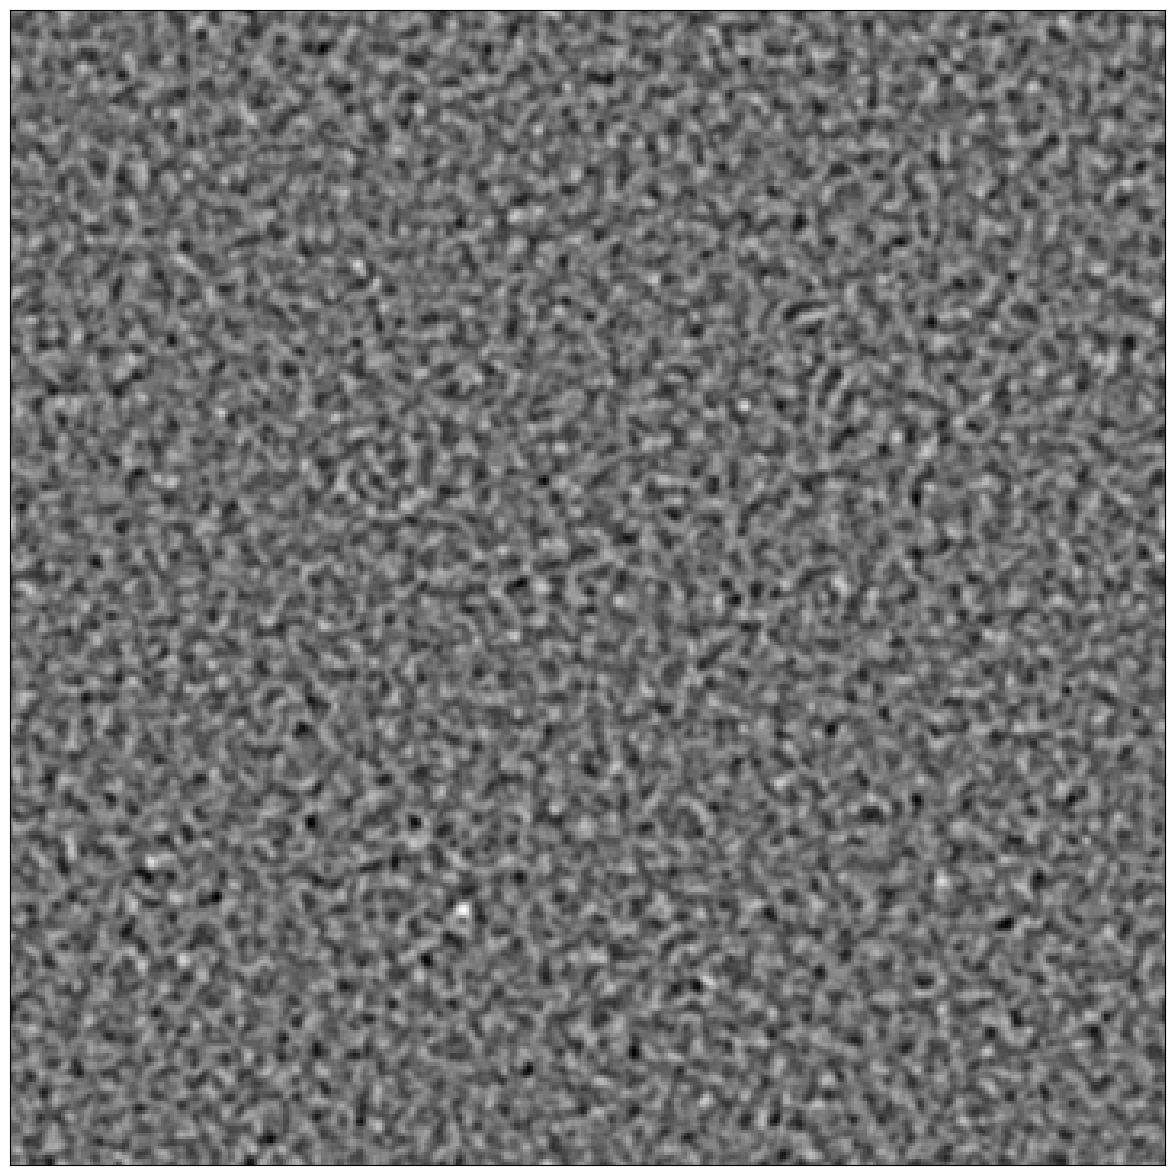

In [26]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

to use it in the function, we need to transform the numpy format to a torch compatible one, which can be first tested on a MWE (minimal working example):

In [27]:
torch.movedim(torch.randn(1, 2, 3), (1, 2, 0), (0, 1, 2)).shape

torch.Size([2, 3, 1])

this now looks like:

In [28]:
image_tens = torch.from_numpy(image)
# swap from H, W, C (numpy) to C, H, W (torch)
image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))
image.shape, image_tens.shape

((360, 360, 1), torch.Size([1, 360, 360]))

Let's transform the image:

In [29]:
image_tunnel_tens = F.grid_sample(image_tens.unsqueeze(0).float(), tunnel_grid, align_corners=False, padding_mode='border')
image_tunnel_tens.shape

torch.Size([1, 1, 360, 360])

and transform it back to numpy:

In [30]:
image_tunnel_tens = image_tunnel_tens.squeeze(0).squeeze(0)
image_tunnel = image_tunnel_tens.numpy()
image_tunnel.shape

(360, 360)

In [31]:
image_tunnel = image_tunnel * grid_mask
image_tunnel = image_tunnel / grid_depth.numpy()
image_tunnel /= image_tunnel.max()
image_tunnel.shape

(360, 360)

and display it:

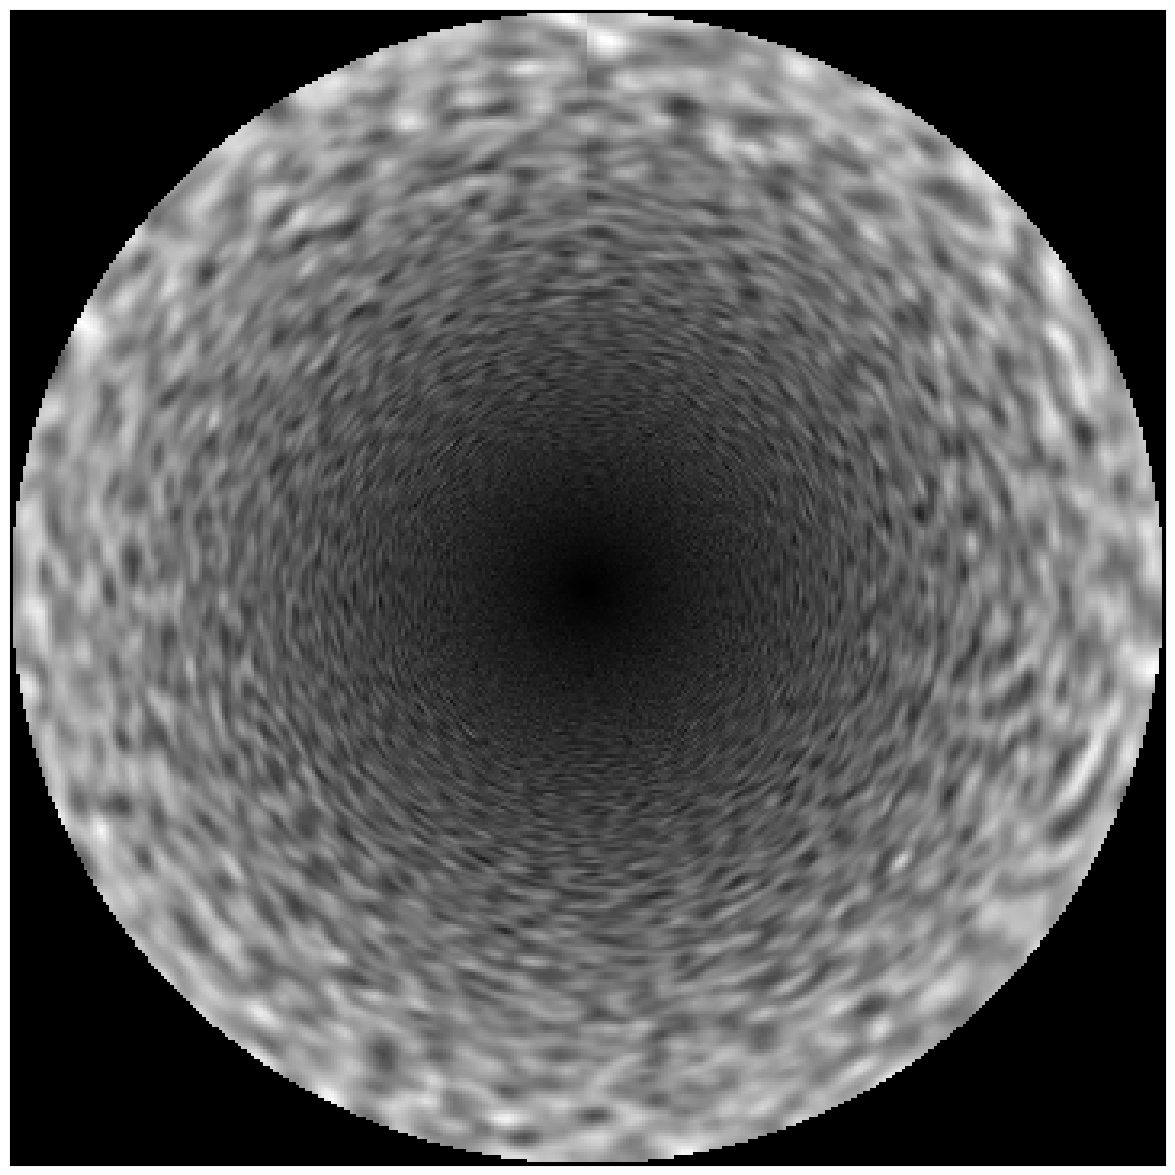

In [32]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_tunnel, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

We mapped a texture to the cylinder and we may simulate motion by moving the texture. One feature of static Motion Clouds is their periodicity, such that there will be no border effects when "rolling" the image progressively.

### wrapping up and make a movie


Now that we have all elements, let's wrap them up in a single function and export the result as a

In [33]:
# %pip install imageio[ffmpeg]

import imageio
def make_mp4(moviename, fnames, fps):
    # Create a video writer object
    writer = imageio.get_writer(moviename, fps=fps)  # Adjust the fps as needed

    # Write frames to the video
    for fname in fnames:
        img = imageio.v2.imread(fname)
        writer.append_data(img)

    # Close the writer
    writer.close()
    return moviename


In [34]:
import matplotlib

UPSCALE = 2
image_size_az, image_size_el = 368*UPSCALE, 368*UPSCALE

def make_shots(figname, 
               image_size_az=image_size_az, image_size_el=image_size_el, 
               VA = torch.pi/4,
               P = 10., # period for the mapped image
               cache_path='/tmp',
               do_mask=True,
               do_distance=True,
               fps = 60 # frames per second
    ):

    az = torch.linspace(-VA/2, VA/2, image_size_az)
    el = torch.linspace(-VA/2, VA/2, image_size_el)

    # Create a meshgrid
    grid_az, grid_el = torch.meshgrid(az, el, indexing='ij')

    grid_theta = torch.arctan2(grid_el, grid_az) / (torch.pi)
    grid_mask = (torch.sqrt(grid_az**2+grid_el**2) < VA / 2).float().numpy()
    grid_depth = 1/torch.tan(torch.sqrt(grid_az**2+grid_el**2))
    grid_depth_mod = 2 * torch.remainder(grid_depth, P) / P -1


    tunnel_grid = torch.stack((grid_theta, grid_depth_mod), 2)
    tunnel_grid = tunnel_grid.unsqueeze(0) # add batch dim

    fx, fy, ft = mc.get_grids(image_size_az, image_size_el, 1)
    image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))
    image_tens = torch.from_numpy(image)
    # swap from H, W, C (numpy) to C, H, W (torch)
    image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))


    fnames = []
    figname_ = figname.split('/')[-1]

    for t in range(image_size_az):
        fname = f'{cache_path}/{figname_}_{t}.png'

        image_tens_ = torch.roll(image_tens, shifts=-t, dims=1)

        image_tunnel_tens = F.grid_sample(image_tens_.unsqueeze(0).float(), tunnel_grid, align_corners=False, padding_mode='border')
        image_tunnel_tens = image_tunnel_tens.squeeze(0).squeeze(0)
        image_tunnel = image_tunnel_tens.numpy()
        if do_mask: image_tunnel = image_tunnel * grid_mask
        if do_distance:
            image_tunnel = image_tunnel / grid_depth.numpy()
            image_tunnel /= image_tunnel.max()

        imageio.imwrite(fname, (image_tunnel * 255).astype(np.uint8), format='png')

        fnames.append(fname)

    make_mp4(figname, fnames, fps=fps)
    for fname in fnames: os.remove(fname)    
    return figname # returns filename


In [ ]:
figname = os.path.join('../files/2025-06-09-extending-the-high-phi-illusion.mp4')
# %rm {figname} # HACK

In [36]:
if not os.path.isfile(figname): 
    figname = make_shots(figname)

## some book keeping for the notebook

In [43]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,imageio  -r -g -b

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 8.30.0

numpy     : 2.2.4
matplotlib: 3.10.1
imageio   : 2.37.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local

Git hash: dbe116c1c348a92e80613067d17ddef33ee24427

Git repo: https://github.com/laurentperrinet/sciblog

Git branch: master

